In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import gc
import h5py
from sklearn.preprocessing import StandardScaler
import librosa

In [2]:
wav_song_path = "IsoDatasetPro/Songs/"
IsoDatasetPro = "IsoDatasetPro/"
standardized_file = "IsoDatasetPro/Standardized"
chord_vocab_file = "IsoDatasetPro/chord_vocabulary_12_keys.csv"
train_file = "IsoDatasetPro/train.csv"
test_file = "IsoDatasetPro/test.csv"
validation_file = "IsoDatasetPro/validation.csv"

# Dataset Expansion
exp_song_path = "IsoDatasetPro/Expanded/Songs"
exp_file_path = "IsoDatasetPro/Expanded/Files"


In [3]:
# Define categories (merging 'X' into 'N')
roots = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'N', 'X']
basses = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'N', 'X']
triads = ['Major', 'Minor', 'Diminished', 'Augmented', 'Sus2', 'Sus4', 'N', 'X']
fourths = ['dim7', 'min7', 'maj7', 'maj6', 'N', 'X']

In [4]:
standardized_file = exp_file_path
wav_song_path = exp_song_path

Processing sample: 01_01_(-1).csv
Processing sample: 01_01_(-2).csv
Processing sample: 01_01_(-3).csv
Processing sample: 01_01_(-4).csv
Processing sample: 01_01_(-5).csv
Processing sample: 01_01_(0).csv
Processing sample: 01_01_(1).csv
Processing sample: 01_01_(2).csv
Processing sample: 01_01_(3).csv
Processing sample: 01_01_(4).csv
Processing sample: 01_01_(5).csv
Processing sample: 01_02_(-1).csv
Processing sample: 01_02_(-2).csv
Processing sample: 01_02_(-3).csv
Processing sample: 01_02_(-4).csv
Processing sample: 01_02_(-5).csv
Processing sample: 01_02_(0).csv
Processing sample: 01_02_(1).csv
Processing sample: 01_02_(2).csv
Processing sample: 01_02_(3).csv
Processing sample: 01_02_(4).csv
Processing sample: 01_02_(5).csv
Processing sample: 01_03_(-1).csv
Processing sample: 01_03_(-2).csv
Processing sample: 01_03_(-3).csv
Processing sample: 01_03_(-4).csv
Processing sample: 01_03_(-5).csv
Processing sample: 01_03_(0).csv
Processing sample: 01_03_(1).csv
Processing sample: 01_03_(2)

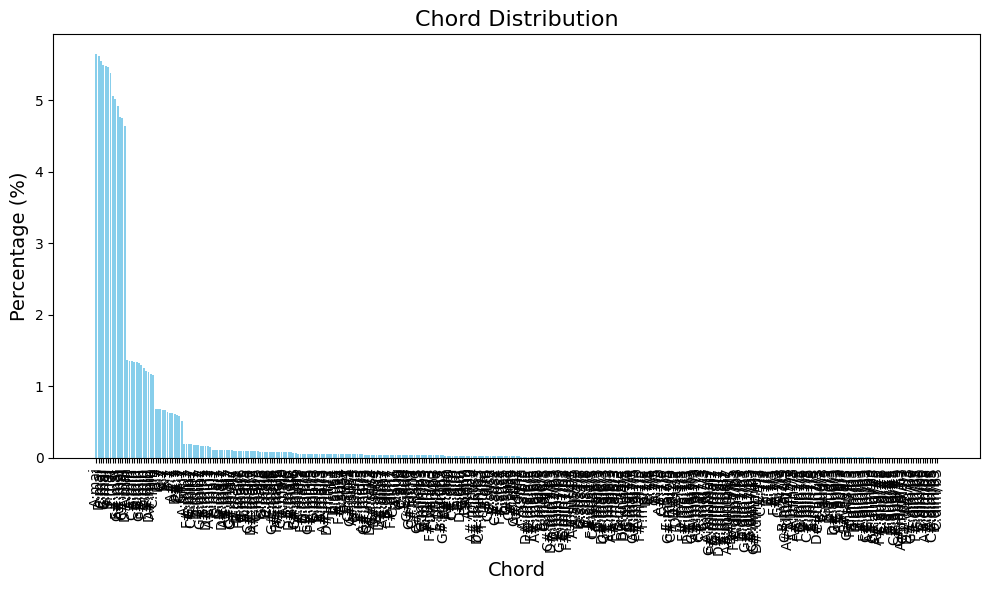

In [5]:
# Dictionary to store chord counts
chord_counts = Counter()
total_chords = 0

# Loop through each sample folder
for file in os.listdir(standardized_file):
    print(f"Processing sample: {file}")
    
    combined_file = os.path.join(standardized_file, file)
    
    if os.path.exists(combined_file):
        df = pd.read_csv(combined_file)
    
        # Count chords in this file
        chord_counts.update(df['Chord_Label'])
        total_chords += len(df['Chord_Label'])

# Calculate percentages for unique chords
chord_percentages = {chord: (count / total_chords) * 100 for chord, count in chord_counts.items()}

# Convert to DataFrame for better readability
chord_distribution_df = pd.DataFrame(list(chord_percentages.items()), columns=['Chord', 'Percentage'])

# Add chord counts to the DataFrame
chord_distribution_df['Chord_Count'] = chord_distribution_df['Chord'].map(chord_counts)

# Sort by percentage (descending)
chord_distribution_df = chord_distribution_df.sort_values(by='Percentage', ascending=False)

print(chord_distribution_df)

# Plotting the chord distribution
plt.figure(figsize=(10, 6))
plt.bar(chord_distribution_df['Chord'], chord_distribution_df['Percentage'], color='skyblue')

# Adding labels and title
plt.xlabel('Chord', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Chord Distribution', fontsize=16)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

chord_distribution_df.to_csv('IsoDatasetPro/ChordDistro.csv')

In [6]:
# chord_distribution_df = pd.read_csv('IsoDatasetPro/ChordDistro.csv', header = 0)
# Calculate the rare chord threshold
rare_threshold = (0.05 / chord_distribution_df['Percentage'].sum()) * 100

# Identify rare chords based on the threshold
rare_chords = chord_distribution_df[chord_distribution_df["Percentage"] < rare_threshold]['Chord'].tolist()
non_rare_chords = chord_distribution_df[chord_distribution_df["Percentage"] >= rare_threshold]['Chord'].tolist()

print(f"🔍 Identified {len(rare_chords)} rare chords:")
print(rare_chords)

🔍 Identified 259 rare chords:
['A#:maj/3', 'D#:min/5', 'F:maj/3', 'E:sus4', 'D:sus4', 'B:sus4', 'F#:sus4', 'G:sus4', 'A:sus4', 'F:sus4', 'C:min/5', 'G#:sus4', 'A#:sus4', 'G:min/5', 'E:maj/3', 'F:min/5', 'A#:min/5', 'G#:maj/3', 'C#:min/5', 'D#:maj/3', 'C#:sus4', 'D#:sus4', 'B:min/5', 'D#:dim7', 'E:dim7', 'A#:dim7', 'B:dim7', 'G:dim7', 'F#:dim7', 'C:dim7', 'D:aug', 'A:aug', 'G:aug', 'C:aug', 'E:aug', 'G#:aug', 'G#:dim7', 'C#:dim7', 'F:aug', 'C#:maj/3', 'D:min/b3', 'G:min/b3', 'E:min/b3', 'A:min/b3', 'F#:min/b3', 'D#:aug', 'C:min/b3', 'B:aug', 'D:dim7', 'B:min/b3', 'G#:min/b3', 'F#:aug', 'A#:dim', 'F#:dim', 'C#:dim', 'E:dim', 'D:dim', 'D#:dim', 'G:dim', 'F:dim7', 'A:dim', 'A#:aug', 'A#:min/b3', 'C:sus4', 'D#:min/b3', 'C#:min/b3', 'F:min/b3', 'F:dim', 'B:dim', 'G#:dim', 'C:sus2', 'B:sus2', 'C#:sus2', 'F:sus2', 'F#:sus2', 'E:sus2', 'D:sus2', 'G:sus2', 'C#:aug', 'A:sus2', 'G#:sus2', 'A#:sus2', 'A:dim7', 'C:dim', 'A:maj6/5', 'D#:maj6/5', 'D:maj6/5', 'F#:maj6/5', 'F:maj6/5', 'A#:maj6/5', 'C:ma

In [7]:
# Step 1: Collecting song data and chord info
song_to_chords = defaultdict(set)  # Mapping from song ID to chords
chord_to_songs = defaultdict(set)  # Mapping from chord to song IDs

# Loop through each sample file in the directory
for file in os.listdir(standardized_file):
    if file.endswith(".csv"):  # Ensure only CSV files are processed
        print(f"Processing sample: {file}")
        
        # Get song ID from file name (without extension)
        song_id = os.path.splitext(file)[0]
        combined_file = os.path.join(standardized_file, file)
        
        if os.path.exists(combined_file):
            df = pd.read_csv(combined_file)
            
            # Extract the unique chord labels for this song
            unique_chords = set(df['Chord_Label'].unique())
            
            # Store song → chords mapping
            song_to_chords[song_id] = unique_chords

            # Store chord → songs mapping
            for chord in unique_chords:
                chord_to_songs[chord].add(song_id)

print(f"🎯 {len(song_to_chords)} songs and {len(chord_to_songs)} unique chords found.")

# Start with rare chord songs (so they are included in all splits)
rare_songs = {song for chord in rare_chords for song in chord_to_songs[chord]}
print(f"🎯 {len(rare_songs)} songs contain rare chords.")

# Serialize and save the dictionary to a file
with open('IsoDatasetPro/songstochords.pkl', 'wb') as file:
    pickle.dump(song_to_chords, file)

with open('IsoDatasetPro/chordstosongs.pkl', 'wb') as file:
    pickle.dump(chord_to_songs, file)


Processing sample: 01_01_(-1).csv
Processing sample: 01_01_(-2).csv
Processing sample: 01_01_(-3).csv
Processing sample: 01_01_(-4).csv
Processing sample: 01_01_(-5).csv
Processing sample: 01_01_(0).csv
Processing sample: 01_01_(1).csv
Processing sample: 01_01_(2).csv
Processing sample: 01_01_(3).csv
Processing sample: 01_01_(4).csv
Processing sample: 01_01_(5).csv
Processing sample: 01_02_(-1).csv
Processing sample: 01_02_(-2).csv
Processing sample: 01_02_(-3).csv
Processing sample: 01_02_(-4).csv
Processing sample: 01_02_(-5).csv
Processing sample: 01_02_(0).csv
Processing sample: 01_02_(1).csv
Processing sample: 01_02_(2).csv
Processing sample: 01_02_(3).csv
Processing sample: 01_02_(4).csv
Processing sample: 01_02_(5).csv
Processing sample: 01_03_(-1).csv
Processing sample: 01_03_(-2).csv
Processing sample: 01_03_(-3).csv
Processing sample: 01_03_(-4).csv
Processing sample: 01_03_(-5).csv
Processing sample: 01_03_(0).csv
Processing sample: 01_03_(1).csv
Processing sample: 01_03_(2)

In [8]:
# Specify the ratio for each split
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15

In [9]:
# Initialize the sets for the splits
train_songs = set()
val_songs = set()
test_songs = set()

# Store the total number of songs
total_songs = len(song_to_chords)

# For rare chords, distribute their songs across splits
for chord in rare_chords:
    songs_with_chord = list(chord_to_songs[chord])

    if len(songs_with_chord) == 1:
        # If only one song with this chord, add to all splits
        for split in [train_songs, val_songs, test_songs]:
            if songs_with_chord[0] not in split:
                split.add(songs_with_chord[0])
    elif len(songs_with_chord) == 2:
        # If only two songs, assign one to train/val, other to test
        if songs_with_chord[0] not in train_songs and len(train_songs) / total_songs < train_ratio:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs and len(val_songs) / total_songs < val_ratio:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[1] not in test_songs and len(test_songs) / total_songs < test_ratio:
            test_songs.add(songs_with_chord[1])
    elif len(songs_with_chord) == 3:
        # If three songs, assign one to each split
        if songs_with_chord[0] not in train_songs:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[2] not in test_songs:
            test_songs.add(songs_with_chord[2])
    else:
        # More than three songs, check and assign before shuffling
        # Avoid duplicating songs in the splits
        available_splits = {
            'train': train_songs,
            'val': val_songs,
            'test': test_songs
        }

        # Add the first available songs to the splits if they don't already exist
        for idx, song in enumerate(songs_with_chord[:3]):
            if song not in train_songs and available_splits['train'] != train_songs:
                train_songs.add(song)
            elif song not in val_songs and available_splits['val'] != val_songs:
                val_songs.add(song)
            elif song not in test_songs and available_splits['test'] != test_songs:
                test_songs.add(song)

        # Shuffle the remaining songs and assign them based on proportions
        np.random.shuffle(songs_with_chord[3:])
        remaining_songs = songs_with_chord[3:]

        for song in remaining_songs:
            if song not in train_songs and len(train_songs) / total_songs < train_ratio:
                train_songs.add(song)
            elif song not in val_songs and len(val_songs) / total_songs < val_ratio:
                val_songs.add(song)
            elif song not in test_songs and len(test_songs) / total_songs < test_ratio:
                test_songs.add(song)

# For non-rare chords, distribute their songs across splits
for chord in non_rare_chords:
    songs_with_chord = list(chord_to_songs[chord])

    if len(songs_with_chord) == 1:
        # If only one song with this chord, add to all splits
        for split in [train_songs, val_songs, test_songs]:
            if songs_with_chord[0] not in split:
                split.add(songs_with_chord[0])
    elif len(songs_with_chord) == 2:
        # If only two songs, assign one to train/val, other to test
        if songs_with_chord[0] not in train_songs and len(train_songs) / total_songs < train_ratio:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs and len(val_songs) / total_songs < val_ratio:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[1] not in test_songs and len(test_songs) / total_songs < test_ratio:
            test_songs.add(songs_with_chord[1])
    elif len(songs_with_chord) == 3:
        # If three songs, assign one to each split
        if songs_with_chord[0] not in train_songs:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[2] not in test_songs:
            test_songs.add(songs_with_chord[2])
    else:
        # More than three songs, check and assign before shuffling
        # Avoid duplicating songs in the splits
        available_splits = {
            'train': train_songs,
            'val': val_songs,
            'test': test_songs
        }

        # Add the first available songs to the splits if they don't already exist
        for idx, song in enumerate(songs_with_chord[:3]):
            if song not in train_songs and available_splits['train'] != train_songs:
                train_songs.add(song)
            elif song not in val_songs and available_splits['val'] != val_songs:
                val_songs.add(song)
            elif song not in test_songs and available_splits['test'] != test_songs:
                test_songs.add(song)

        # Shuffle the remaining songs and assign them based on proportions
        np.random.shuffle(songs_with_chord[3:])
        remaining_songs = songs_with_chord[3:]

        for song in remaining_songs:
            if song not in train_songs and len(train_songs) / total_songs < train_ratio:
                train_songs.add(song)
            elif song not in val_songs and len(val_songs) / total_songs < val_ratio:
                val_songs.add(song)
            elif song not in test_songs and len(test_songs) / total_songs < test_ratio:
                test_songs.add(song)

# Final split counts
print(f"🎯 Final Split Counts - Train: {len(train_songs)}, Val: {len(val_songs)}, Test: {len(test_songs)}")


🎯 Final Split Counts - Train: 999, Val: 189, Test: 200


In [10]:
# Optionally, print or return the final splits for further use
train_songs = list(train_songs)
val_songs = list(val_songs)
test_songs = list(test_songs)

# Save the final splits to CSV files (optional)
train_songs_df = pd.DataFrame({'song_id': train_songs})
val_songs_df = pd.DataFrame({'song_id': val_songs})
test_songs_df = pd.DataFrame({'song_id': test_songs})

train_songs_df.to_csv(train_file, index=False)
val_songs_df.to_csv(validation_file, index=False)
test_songs_df.to_csv(test_file, index=False)

print("🎉 Final splits saved successfully!")


🎉 Final splits saved successfully!


In [11]:
# ONE HOT ENCODING

# Load the chord vocabulary CSV
chord_vocab_df = pd.read_csv(chord_vocab_file)

root_map = {note: i for i, note in enumerate(roots)}
bass_map = {note: i for i, note in enumerate(basses)}
triad_map = {triad: i for i, triad in enumerate(triads)}
fourth_map = {fourth: i for i, fourth in enumerate(fourths)}

def chord_to_vector(chord_label):
    """
    Convert chord label (e.g., 'C:maj7') into a 42-dimensional one-hot encoding
    by referring to the chord vocab CSV to extract the root, bass, triad, and fourth note.
    """
    # Lookup the chord label in the chord vocabulary
    chord_row = chord_vocab_df[chord_vocab_df['chord_name'] == chord_label]
    
    if chord_row.empty:
        raise ValueError(f"Chord label '{chord_label}' not found in the chord vocabulary.")

    # Extract the root, bass, triad, and fourth from the vocabulary
    root = chord_row['root'].values[0]
    bass = chord_row['bass'].values[0]
    triad = chord_row['triad'].values[0]
    fourth = chord_row['fourth'].values[0]
    chord_index = chord_row['chord_index'].values[0]

    # # Replace 'X' with 'N' (unknown or placeholder)
    # if root == 'X':
    #     root = 'N'
    # if bass == 'X':
    #     bass = 'N'
    # if triad == 'X':
    #     triad = 'N'
    # if fourth == 'X':
    #     fourth = 'N'

    # Map to indices
    root_index = root_map[root]
    bass_index = bass_map[bass]
    triad_index = triad_map[triad]
    fourth_index = fourth_map[fourth]

    # Return the indices instead of the one-hot encoded vector
    return np.array([root_index, bass_index, triad_index, fourth_index, chord_index])

def vector_to_chord(vector):
    """
    Convert a vector of indices back to a chord label (e.g., [0, 0, 0, 1] -> 'C:maj7')
    by referring to the chord vocabulary DataFrame.
    """
    root_index, bass_index, triad_index, fourth_index, chord_index = vector

    # Convert indices back to values using the corresponding arrays
    root_value = roots[root_index]
    bass_value = basses[bass_index]
    triad_value = triads[triad_index]
    fourth_value = fourths[fourth_index]

    # Find the corresponding row in the chord vocabulary
    chord_row_com = chord_vocab_df[
        (chord_vocab_df['root'] == root_value) &
        (chord_vocab_df['bass'] == bass_value) &
        (chord_vocab_df['triad'] == triad_value) &
        (chord_vocab_df['fourth'] == fourth_value)
    ]

    # Lookup the chord label in the chord vocabulary
    chord_row_ind = chord_vocab_df[chord_vocab_df['chord_index'] == chord_index]

    if chord_row_com.empty:
        raise ValueError(f"Chord with values ({root_value}, {bass_value}, {triad_value}, {fourth_value}) not found in the chord vocabulary.")
    if chord_row_ind.empty:
        raise ValueError(f"Chord label '{chord_index}' not found in the chord vocabulary.")
    
    # Return the chord label
    return chord_row_com['chord_name'].values[0], chord_row_ind['chord_name'].values[0]



def clean_chord_vector(x):
    # Step 1: Strip leading/trailing spaces
    x = x.strip()

    # Step 2: Iterate over each character in the string, removing spaces and extracting numbers
    cleaned_values = []
    current_number = ""

    for char in x:
        if char.isdigit():  # If the character is a digit
            current_number += char  # Append the digit to the current number
        elif char == ' ' and current_number:  # If there's a space and a number exists
            cleaned_values.append(int(current_number))  # Convert the current number to int and append it
            current_number = ""  # Reset the current number for the next value
    
    if current_number:  # If there's a number left at the end, append it
        cleaned_values.append(int(current_number))

    # Step 3: Return the cleaned array as a numpy array
    # print(cleaned_values)
    return np.array(cleaned_values)



In [12]:
# # Example usage:
# chord_label = 'X'
# vector = chord_to_vector(chord_label)
# print("Chord to vector:", vector)

# # Assuming the model predicted the following indices:
# predicted_vector = np.array([0, 0, 0, 1, 55])  # Example output from your model
# predicted_chord = vector_to_chord(predicted_vector)
# print("Predicted chord:", predicted_chord)



In [13]:
# CONVERTING CHORD LABEL TO VERCTOR and PADDING To SCLICE

# Loop through each sample file in the directory

slice_size = 300
X_label = "X"  # Label for padding


# Process each CSV file
for file in os.listdir(standardized_file):
    if file.endswith(".csv"):  # Ensure only CSV files are processed
        print(f"Processing sample: {file}")

        # Load CSV
        df = pd.read_csv(os.path.join(standardized_file, file))

        # Ensure row count is a multiple of slice_size (300)
        num_rows = len(df)
        remainder = num_rows % slice_size
        cqt_columns = df.columns[:192]

        if remainder > 0:
            padding_needed = slice_size - remainder
            print(f"Padding {padding_needed} rows for {file} to align with {slice_size}.")

            # Create a DataFrame with padding rows for the relevant columns (chroma and chord label)
            pad_df = pd.DataFrame(np.zeros((padding_needed, 192)), columns=cqt_columns)  # Chroma columns filled with zeros
            pad_df['Chord_Label'] = [X_label] * padding_needed  # Chord label column filled with 'X'

            # Append padding to the relevant columns of the DataFrame
            df = pd.concat([df, pad_df], ignore_index=True)

        # Apply librosa normalization only to the first 192 columns
        df.iloc[:, :192] = librosa.util.normalize(df.iloc[:, :192].to_numpy(), axis=0)

        # Convert Chord Labels to Vectors
        df["Chord_Vector"] = df["Chord_Label"].apply(chord_to_vector)

        df["Chord_Vector"] = df["Chord_Vector"].apply(lambda x: clean_chord_vector(x) if isinstance(x, str) else x)

        # Save back to CSV
        df.to_csv(os.path.join(standardized_file, file), index=False)

        print(f"✅ Processed and saved: {file}")

print("🎉 Chord labels padded and converted successfully!")


Processing sample: 01_01_(-1).csv
Padding 182 rows for 01_01_(-1).csv to align with 300.
✅ Processed and saved: 01_01_(-1).csv
Processing sample: 01_01_(-2).csv
Padding 182 rows for 01_01_(-2).csv to align with 300.
✅ Processed and saved: 01_01_(-2).csv
Processing sample: 01_01_(-3).csv
Padding 182 rows for 01_01_(-3).csv to align with 300.
✅ Processed and saved: 01_01_(-3).csv
Processing sample: 01_01_(-4).csv
Padding 182 rows for 01_01_(-4).csv to align with 300.
✅ Processed and saved: 01_01_(-4).csv
Processing sample: 01_01_(-5).csv
Padding 182 rows for 01_01_(-5).csv to align with 300.
✅ Processed and saved: 01_01_(-5).csv
Processing sample: 01_01_(0).csv
Padding 182 rows for 01_01_(0).csv to align with 300.
✅ Processed and saved: 01_01_(0).csv
Processing sample: 01_01_(1).csv
Padding 182 rows for 01_01_(1).csv to align with 300.
✅ Processed and saved: 01_01_(1).csv
Processing sample: 01_01_(2).csv
Padding 182 rows for 01_01_(2).csv to align with 300.
✅ Processed and saved: 01_01_(

In [14]:
# Splitting the data
slice_size = 300
num_classes = {"root": 14, "bass": 14, "triad": 8, "fourth": 6}

# Read the index files that contain the song IDs for each split
train_songs = pd.read_csv(train_file, header=0).squeeze()
test_songs = pd.read_csv(test_file, header=0).squeeze()
val_songs = pd.read_csv(validation_file, header=0).squeeze()

# Define a function to load CSV files based on the split
def load_data_for_split(split_songs, type):
    data = np.empty((0, 192))
    for song_id in split_songs:
        print(song_id)
        file_path = os.path.join(standardized_file, f'{song_id}.csv')  # Assuming each song ID corresponds to a CSV file
        song_data = pd.read_csv(file_path , header=0)
        print(len(song_data))
        song_data_array = song_data.iloc[:, :192].to_numpy()
        data = np.concatenate([data, song_data_array], axis=0)
        gc.collect()
        
    data = data.reshape((-1, slice_size, 192))
    if type == 'train':
        os.remove('IsoDatasetPro/Train/Train.h5')
        with h5py.File('IsoDatasetPro/Train/Train.h5', 'w') as f:
            f.create_dataset('X_train', data=data)
    elif type == 'val':
        os.remove('IsoDatasetPro/Val/Val.h5')
        with h5py.File('IsoDatasetPro/Val/Val.h5', 'w') as f:
            f.create_dataset('X_val', data=data)
    elif type == 'test':
        os.remove('IsoDatasetPro/Test/Test.h5')
        with h5py.File('IsoDatasetPro/Test/Test.h5', 'w') as f:
            f.create_dataset('X_test', data=data)
    gc.collect()



def load_note_data(split_songs, type):
    y_root_train = np.array([])
    y_bass_train = np.array([])
    y_triad_train = np.array([])
    y_fourth_train = np.array([])

    for song_id in split_songs:
        print(song_id)
        file_path = os.path.join(standardized_file, f'{song_id}.csv')  # Assuming each song ID corresponds to a CSV file
        song_data = pd.read_csv(file_path)
        # Apply the function to your data
        song_data["Chord_Vector"] = song_data["Chord_Vector"].apply(lambda x: clean_chord_vector(x) if isinstance(x, str) else x)
        # print(song_data['Chord_Vector'])
        # Extract one-hot encoded labels for train, validation, and test splits
        y_root_train = np.concatenate([y_root_train, np.array([vec[0] for vec in song_data["Chord_Vector"]])])
        y_bass_train = np.concatenate([y_bass_train, np.array([vec[1] for vec in song_data["Chord_Vector"]])])
        y_triad_train = np.concatenate([y_triad_train, np.array([vec[2] for vec in song_data["Chord_Vector"]])])
        y_fourth_train = np.concatenate([y_fourth_train, np.array([vec[3] for vec in song_data["Chord_Vector"]])])
        # y_chord_index_train = np.array([vec[4] for vec in song_data["Chord_Vector"]])

    # Reshape padded labels for training
    y_root_train_padded_reshaped = y_root_train.reshape((-1, slice_size))
    y_bass_train_padded_reshaped = y_bass_train.reshape((-1, slice_size))
    y_triad_train_padded_reshaped = y_triad_train.reshape((-1, slice_size))
    y_fourth_train_padded_reshaped = y_fourth_train.reshape((-1, slice_size))
    # y_chord_train_padded_reshaped = y_chord_train_padded.reshape((-1, slice_size))

    # Ensure the indices are integers within the valid range
    y_root_train_padded_reshaped = y_root_train_padded_reshaped.astype(int)
    y_bass_train_padded_reshaped = y_bass_train_padded_reshaped.astype(int)
    y_triad_train_padded_reshaped = y_triad_train_padded_reshaped.astype(int)
    y_fourth_train_padded_reshaped = y_fourth_train_padded_reshaped.astype(int)

    # print(y_root_train_padded_reshaped)

    assert np.all(y_root_train_padded_reshaped >= 0) and np.all(y_root_train_padded_reshaped < num_classes["root"]), "Root indices are out of range!"
    assert np.all(y_bass_train_padded_reshaped >= 0) and np.all(y_bass_train_padded_reshaped < num_classes["bass"]), "Bass indices are out of range!"
    assert np.all(y_triad_train_padded_reshaped >= 0) and np.all(y_triad_train_padded_reshaped < num_classes["triad"]), "Triad indices are out of range!"
    assert np.all(y_fourth_train_padded_reshaped >= 0) and np.all(y_fourth_train_padded_reshaped < num_classes["fourth"]), "Fourth indices are out of range!"


    # Convert labels to categorical (One-hot encoding)
    y_root = np.eye(num_classes["root"])[y_root_train_padded_reshaped]
    y_bass = np.eye(num_classes["bass"])[y_bass_train_padded_reshaped]
    y_triad = np.eye(num_classes["triad"])[y_triad_train_padded_reshaped]
    y_fourth = np.eye(num_classes["fourth"])[y_fourth_train_padded_reshaped]
    # y_chord = np.eye(num_classes["chord_index"])[y_chord_train_padded_reshaped]

    if type == 'train' :
        with h5py.File('IsoDatasetPro/Train/Train.h5', 'a') as f:
            f.create_dataset('root', data=y_root)
        with h5py.File('IsoDatasetPro/Train/Train.h5', 'a') as f:
            f.create_dataset('bass', data=y_bass)
        with h5py.File('IsoDatasetPro/Train/Train.h5', 'a') as f:
            f.create_dataset('triad', data=y_triad)
        with h5py.File('IsoDatasetPro/Train/Train.h5', 'a') as f:
            f.create_dataset('fourth', data=y_fourth)

    elif type == 'val':
        with h5py.File('IsoDatasetPro/Val/Val.h5', 'a') as f:
            f.create_dataset('root', data=y_root)
        with h5py.File('IsoDatasetPro/Val/Val.h5', 'a') as f:
            f.create_dataset('bass', data=y_bass)
        with h5py.File('IsoDatasetPro/Val/Val.h5', 'a') as f:
            f.create_dataset('triad', data=y_triad)
        with h5py.File('IsoDatasetPro/Val/Val.h5', 'a') as f:
            f.create_dataset('fourth', data=y_fourth)

    elif type == 'test':
        with h5py.File('IsoDatasetPro/Test/Test.h5', 'a') as f:
            f.create_dataset('root', data=y_root)
        with h5py.File('IsoDatasetPro/Test/Test.h5', 'a') as f:
            f.create_dataset('bass', data=y_bass)
        with h5py.File('IsoDatasetPro/Test/Test.h5', 'a') as f:
            f.create_dataset('triad', data=y_triad)
        with h5py.File('IsoDatasetPro/Test/Test.h5', 'a') as f:
            f.create_dataset('fourth', data=y_fourth)

    print(len(y_root), len(y_bass), len(y_triad), len(y_fourth))
    gc.collect()

    


In [15]:
load_data_for_split(train_songs, 'train')
load_note_data(train_songs, 'train')
gc.collect()

06_07_(-3)
1800
01_13_(-2)
1500
02_07_(0)
1800
09_03_(0)
1500
05_08_(-3)
1800
06_02_(0)
1500
04_05_(-3)
1500
04_03_(4)
1500
08_03_(-3)
2400
05_12_(-5)
1500
02_12_(0)
1800
02_07_(3)
1800
01_10_(-2)
1800
02_02_(1)
1500
01_01_(4)
2100
05_01_(-5)
1800
01_12_(-4)
1500
06_01_(2)
1800
04_02_(0)
1800
08_06_(1)
2400
05_03_(3)
1500
02_04_(-3)
1800
06_09_(2)
1800
03_04_(0)
1500
09_11_(-2)
2700
01_14_(-5)
1800
04_05_(3)
1500
05_09_(-3)
1500
06_08_(0)
2100
03_05_(-2)
1800
01_07_(5)
1500
08_09_(-3)
1800
04_03_(3)
1500
03_02_(4)
1800
04_12_(4)
1800
02_13_(0)
1500
06_11_(2)
1800
06_06_(-2)
2100
08_07_(0)
1800
07_11_(5)
1500
08_11_(3)
1800
09_02_(4)
2100
09_06_(-3)
3000
03_08_(0)
1500
05_04_(-3)
1800
06_09_(-3)
1800
09_03_(-4)
1500
09_03_(-3)
1500
07_09_(3)
1500
05_03_(-2)
1500
02_10_(4)
2100
01_09_(-1)
1500
08_12_(1)
900
08_11_(2)
1800
02_08_(1)
2100
08_06_(-4)
2400
05_13_(1)
1500
01_02_(-3)
1500
03_07_(0)
1500
06_04_(5)
1800
04_06_(2)
1800
03_02_(-4)
1800
09_06_(-2)
3000
05_01_(-2)
1800
09_06_(4)
300

0

In [16]:
load_data_for_split(test_songs, 'test')
load_note_data(test_songs, 'test')
gc.collect()


09_08_(-2)
2700
08_06_(4)
2400
06_07_(-3)
1800
08_09_(-1)
1800
02_13_(1)
1500
02_13_(-5)
1500
03_08_(-3)
1500
06_03_(-4)
2400
09_08_(-4)
2700
04_03_(5)
1500
02_01_(2)
1500
01_01_(5)
2100
06_03_(-3)
2400
01_12_(-4)
1500
01_12_(-3)
1500
08_06_(1)
2400
09_11_(-2)
2700
02_06_(4)
1500
08_09_(-3)
1800
06_06_(5)
2100
07_09_(2)
1500
04_03_(3)
1500
04_12_(4)
1800
02_01_(4)
1500
03_08_(5)
1500
04_03_(-1)
1500
09_01_(-2)
2100
08_07_(0)
1800
08_05_(-5)
1800
09_02_(4)
2100
08_04_(-5)
2100
09_02_(-2)
2100
07_09_(3)
1500
02_01_(1)
1500
08_06_(-5)
2400
02_06_(0)
1500
02_01_(3)
1500
08_06_(-1)
2400
08_06_(-4)
2400
05_13_(1)
1500
03_01_(-4)
1800
09_11_(-3)
2700
09_02_(2)
2100
08_09_(0)
1800
06_07_(-2)
1800
08_04_(2)
2100
06_07_(5)
1800
09_08_(4)
2700
06_07_(-4)
1800
07_09_(0)
1500
08_04_(-4)
2100
09_11_(-1)
2700
07_09_(-5)
1500
03_08_(1)
1500
08_04_(0)
2100
03_01_(0)
1800
08_09_(5)
1800
05_13_(-4)
1500
08_07_(3)
1800
06_07_(1)
1800
09_08_(1)
2700
06_07_(-5)
1800
02_13_(-4)
1500
01_12_(-5)
1500
07_12_(-3

0

In [17]:
load_data_for_split(val_songs, 'val')
load_note_data(val_songs, 'val')
gc.collect()


09_08_(-2)
2700
02_13_(1)
1500
06_07_(-3)
1800
06_12_(-4)
1500
03_01_(4)
1800
03_08_(-3)
1500
06_09_(5)
1800
07_12_(-4)
1800
06_03_(-4)
2400
02_03_(0)
1500
09_08_(-4)
2700
08_03_(-3)
2400
02_01_(2)
1500
06_03_(-3)
2400
06_12_(0)
1500
09_09_(-1)
2100
08_06_(1)
2400
04_11_(-1)
1500
05_13_(-2)
1500
05_09_(-3)
1500
04_12_(4)
1800
02_01_(4)
1500
06_06_(-2)
2100
08_07_(0)
1800
09_09_(-3)
2100
08_05_(-5)
1800
09_02_(4)
2100
03_08_(0)
1500
06_06_(0)
2100
08_04_(-5)
2100
09_02_(-2)
2100
02_01_(1)
1500
06_06_(2)
2100
08_06_(-5)
2400
02_01_(3)
1500
08_06_(-1)
2400
08_03_(-5)
2400
08_06_(-4)
2400
07_05_(-3)
1800
09_02_(2)
2100
06_12_(4)
1500
06_07_(-2)
1800
09_11_(4)
2700
08_04_(2)
2100
06_07_(5)
1800
09_08_(4)
2700
06_07_(-4)
1800
06_03_(5)
2400
08_04_(-4)
2100
06_12_(2)
1500
03_08_(1)
1500
07_05_(1)
1800
08_05_(4)
1800
08_04_(0)
2100
08_07_(3)
1800
06_07_(1)
1800
09_08_(1)
2700
06_07_(-5)
1800
01_12_(-5)
1500
08_07_(-5)
1800
08_07_(1)
1800
05_09_(-1)
1500
09_08_(-5)
2700
03_08_(-1)
1500
02_01_(-

0